In [147]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import plotly.graph_objs as go
import plotly.offline as py
from wordcloud import WordCloud

In [148]:
# Handles replace warning
pd.set_option('future.no_silent_downcasting', True) 
# Suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None  
# Download Packages
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\RyanT\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data Preparation

In [149]:
# Main Dataset
df = pd.read_csv('src/dataprep/data/pets_prepared.csv')

# Reference Datasets
df_breed = pd.read_csv('src/dataprep/data/breed_labels.csv')
df_color = pd.read_csv('src/dataprep/data/color_labels.csv')
df_state = pd.read_csv('src/dataprep/data/state_labels.csv')

## Main Dataset details

In [150]:
print(df.shape)

(14993, 49)


~15k pets, 49 features

Columns contain all information on the pets health, breed and type. Paired with rescuerID.

Bins also exist, which are features that have beem engineered

In [151]:
# Find columns with null/empty values
columns_with_nulls = df.columns[df.isnull().any()]
print("Columns with null values:", columns_with_nulls.tolist())

Columns with null values: ['Name', 'Description', 'BreedName']


Empty name, description is fine, since we can change it to no name and sometimes people are too lazy to put descriptions. Breedname being null may have an impact, but this columns can probably be removed as other breed columns exist.

In [152]:
# Find duplicate values
df["PetID"].drop_duplicates().shape

(14993,)

No duplicate PetIDs

# Data Cleaning

Bins will be dropped first as they provide an over generalized view of data. 
It would be better to see based on the raw data itself rather than having these
bins. Additionally, it is not easy to guarantee each bin is done properly. 
However, the information from each bin may be harvested and repurposed to fit 
my needs

In [153]:
bin_columns = [x for x in df.columns if 'Bin' in x]
df.drop(columns=bin_columns, inplace=True)
df.shape

(14993, 40)

### Breeds & Type

Doing all these together as reference dataset has these 2 details

In [154]:
temp_df = df[['Breed1', 'Breed2', 'BreedName', 'BreedPure', 'Type', 'TypeName']]

In [156]:
# Changing from words to integer
temp_df.loc[:, 'TypeName'] = temp_df['TypeName'].str.lower()
temp_df.loc[:, 'TypeName'] = temp_df['TypeName'].replace( {'dog': 1,
                                                           'cat': 2})

# Checking for non-matching values
comparison = temp_df['Type'] != temp_df['TypeName']
temp_df[comparison].shape

(0, 6)

In [157]:
# Merging breed_labels to this temp df
merged_df = pd.merge(temp_df,
                     df_breed,
                     left_on='Breed1',
                     right_on='BreedID',
                     how='left',
                     suffixes=('','_ref'),
                     indicator=True)

# Filter for rows that are not merged
unmerged = merged_df[merged_df['_merge'] != 'both']
unmerged

,Breed1,Breed2,BreedName,BreedPure,Type,TypeName,BreedID,Type_ref,BreedName_ref,_merge
391,0,26,NaN,N,1,1,NaN,NaN,NaN,left_only
1045,0,307,NaN,N,1,1,NaN,NaN,NaN,left_only
3219,0,266,NaN,N,2,2,NaN,NaN,NaN,left_only
7285,0,307,NaN,N,1,1,NaN,NaN,NaN,left_only
7706,0,205,NaN,N,1,1,NaN,NaN,NaN,left_only


Since it just leaves out breed1 values, we can just take breed2 and fill in the relevant fields

In [159]:
# To check if by chance Breed1 is equal to Breed2
comparison = (df['Breed1'] == df['Breed2'])
print(df[comparison].shape)

(1510, 40)


Presence of duped values so remove accordingly in cleaning

## Name

In [160]:
temp_df = df[['Name','NameorNO', 'AdoptedName']]

In [161]:
temp_df['Name'][temp_df['NameorNO'].apply(lambda x: x == 'N')].unique()

array(['No Name Yet', 'No Name', 'Not Yet Named', 'Unnamed', 'No Names',
       'Not Yet', 'No Names Yet', 'Noname', 'Not Given Yet', 'Unamed',
       'Nil', 'Not Given', 'Not Named', 'NO NAME', 'Not Yet Name',
       'No Name Kitties', 'NIL', "No Name Yet, It's Up To The Owner",
       'NO NAME YET', 'No Named', 'No Name Yet (Must Neuter)',
       'No Name For Now', 'No Name 2'], dtype=object)

In [162]:
temp_df.loc[temp_df['Name'].isnull(), 'NameorNO'] = 'N'
temp_df[temp_df['Name'].isnull()].head(3)

,Name,NameorNO,AdoptedName
1104,NaN,N,Y
1419,NaN,N,N
1982,NaN,N,Y


In [163]:
# Handle Names First
temp_df['NameLower'] = temp_df['Name'].str.lower()
temp_df['NameLower'].loc[(temp_df['NameLower'] \
                    .str.contains('name', 
                                  na=False, 
                                  case=False)) & (temp_df['NameorNO']=='Y')]
temp_df['NameLower'].fillna('', inplace=True)

In [164]:
tokens = []
for text in temp_df['NameLower'][(temp_df['NameLower'].str.lower().str.contains('name')) & ((temp_df['NameorNO']=='Y'))]:
    tokens.extend(word_tokenize(str(text).lower()))
word_counts = Counter(tokens)
most_common_words = word_counts.most_common(5)
for word, count in most_common_words:
    print(f"{word}: {count}")

name: 41
(: 21
): 21
no: 16
yet: 12


In [165]:
bigrams = list(ngrams(tokens, 2))
bigram_counts = Counter(bigrams)
most_common_bigrams = bigram_counts.most_common(5) 
for bigram, count in most_common_bigrams:
    print(f"{bigram}: {count}")

('no', 'name'): 14
('name', ')'): 10
('(', 'no'): 7
('temporary', 'name'): 6
('name', 'yet'): 5


Naming conventions in `Name` do not follow the ddict rule. However, the `NameorNo` column helps us identify whether a pet has a name or not clearly, on top of the null values as per stated previously. 

As we can also see, the `AdoptedName` column gives no meaning, be it to whether the pet has a name before its adopted. Even if the pet doesnt have a name before, `AdoptedName` will still have a "Y" . Even then, it would provide no benefits to data analysis.

As we can see, there are many names incidated with "Y" in NameorNo column with No names. This should be handled in data cleaning. n-grams are used to figure out the top ocmbination of words to remove

### Seeing if special characters are a problem

In [167]:
def contains_non_english(text):
    if isinstance(text, str):
        return not all(ord(char) < 128 for char in text)
    return False  # return false for nan values

In [168]:
print("no. of rows containing non-english text:",
       temp_df[temp_df['NameLower'].apply(contains_non_english)].shape[0])
temp_df[temp_df['NameLower'].apply(contains_non_english)].sample(n=5)

no. of rows containing non-english text: 161


,Name,NameorNO,AdoptedName,NameLower
4702,Crocs å¤§é ­,Y,Y,crocs å¤§é ­
9822,Brownie The Active Cutie â¥,Y,Y,brownie the active cutie â¥
8713,Little Charcoal å°ç­ç­,Y,Y,little charcoal å°ç­ç­
2010,å°çº¢èæç«åª,Y,Y,å°çº¢èæç«åª
3098,â¡ 3 Puppies â¡ Taman Bahagia LRT,Y,Y,â¡ 3 puppies â¡ taman bahagia lrt


Could be emojis or gibberish

### Summary

In [169]:
df = df.drop(['BreedName', 'BreedPure', 'TypeName', 'GenderName','AdoptedName',
              'MaturitySizeName', 'ColorAmt', 'ColorName', 'FurLengthName',
              'VaccinatedName', 'DewormedName', 'SterilizedName', 
              'HealthName', 'StateName'], axis=1)
df.shape

(14993, 26)

All columns dropped in data cleaning are columns that are either irrelevant,errorneous,duplicates or referenced. As such it will be decreased from 49 to 26 columns, halving many of the features before feature engineering.

Additionally, name column needs to be cleaned by looking at names that contain error values and wrongly assigned names

# EDA

My EDA is done with the question of "What do adoptors prefer" in mind when constructing the arguement.

It will begin with looking at each individual component that ive kept in my data cleaning. 
Normally, this should be sufficient. However, adoption speed is also a key player in identifying whether it is preferred or not. This is as something more prefereable should be adopted faster

As the dataset contains cats and dogs, which is quite manageable, all my comparisons will be made with cats vs dogs. Which does further break down in terms of adoptors preferences for each animal type better

In [170]:
df = pd.read_csv('src\dataprep\data\eda_data.csv')

In [171]:
def percentage_labels(ax, feature):
    total = len(feature)
    for i in ax.patches:
        if i.get_height() > 0:
            percentage = '{:.1f}%'.format(100 * i.get_height()/total)
            x = i.get_x() + i.get_width() / 2
            y = i.get_y() + i.get_height()
            ax.annotate(percentage, (x, y), size = 12, ha='center')

def count_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom',
                    xytext=(0, 5),
                    textcoords='offset points')
    

adoption_speed_list =['Same Day', '1-7 Days', '8-30 Days', '31-90 Days']

Adopted = df['Adopted'] == 1

Cat = df['Type'] == 'Cat'
Dog = df['Type'] == 'Dog'

## Adoption Speed by Type

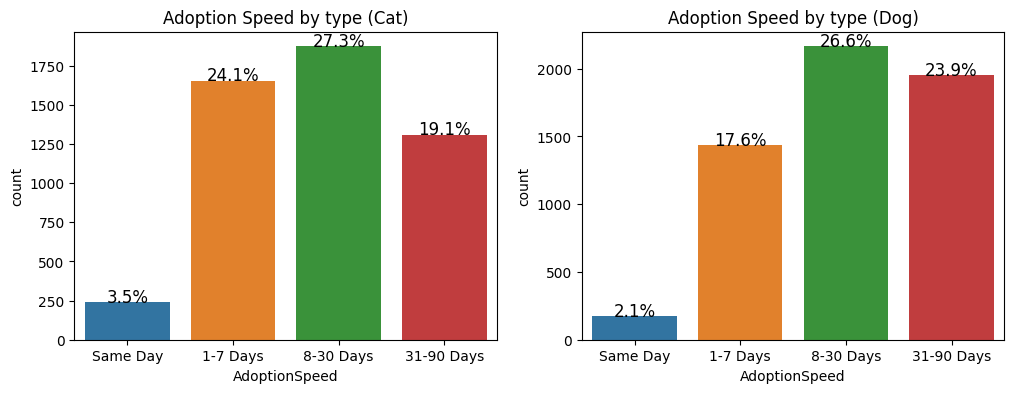

In [174]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1).set_title('Adoption Speed by type (Cat)')

ax = sns.countplot(x='AdoptionSpeed', hue='AdoptionSpeed',
                   order=adoption_speed_list, hue_order=adoption_speed_list,
                   data=df[(Cat) & (Adopted)])

percentage_labels(ax, df[Cat])
plt.subplot(1, 2, 2).set_title('Adoption Speed by type (Dog)')

ax = sns.countplot(x='AdoptionSpeed', hue='AdoptionSpeed',
                   order=adoption_speed_list, hue_order=adoption_speed_list,
                   data=df[(Dog) & (Adopted)])

percentage_labels(ax, df[Dog])

As we can see, this gives a more detailed view on preferences on each animal. More **cats** are adopted quicker within the 1st week of posting(Day 0 to day 7). Meanwhile, more **dogs** are adopted after the 1st week of posting (>8 days up until 90 days). 

However, the majority of pets are adopted in 8-30 Days of posting for both cats and dogs.

### Type Summary: 

1) More dogs are `adopted` compared to cats, same for `not adopted`. 
2) More `Cats` are adopted faster compared to `Dogs` (mostly within the `1st week` of posting)
3) More `Dogs` are adopted compared to `Cats` (after the `1st week` of posting)

## Adoption Rate by Age

Age is distributed across a wide range so we use back the agebins and also modify it to be much more relevant and accurate

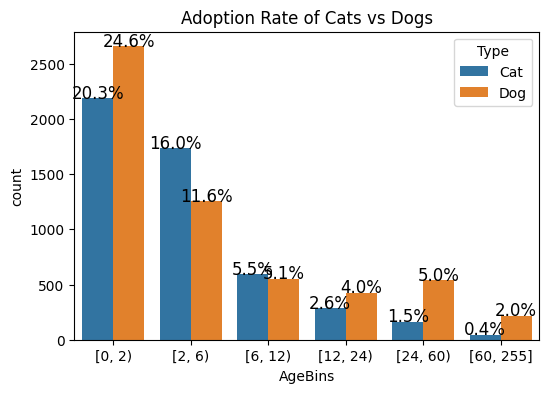

In [175]:
plt.figure(figsize=(6, 4))
label = ['[0, 2)', '[2, 6)', '[6, 12)', '[12, 24)', '[24, 60)', '[60, 255]']
ax = sns.countplot(x='AgeBins', hue='Type', order=label, data=df[Adopted])
plt.title('Adoption Rate of Cats vs Dogs')
percentage_labels(ax, df[Adopted])

Even though the range of the age bin from 60-255 is larger than the rest, it still sums up to be a minsicule % of total data. Indicating that past 60, the chances of adoption are quite low. Additionally the highest rates of adoption comes within the age of the animal being 0-2 months. Additionally, there is a decreasing trend for both cats and dogs, where as the age of the animal increases, the likelihood of adoption decreases

## Adoption Rate by Breed

Here we look at 2 things, pure breed and mixed breeds. 

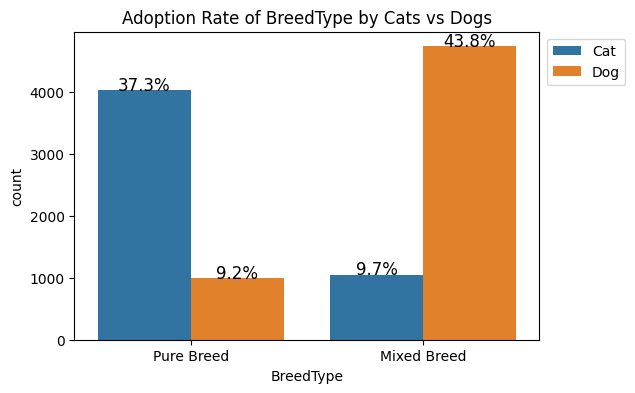

In [176]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='BreedType', hue='Type', data=df[Adopted])
plt.title('Adoption Rate of BreedType by Cats vs Dogs')
percentage_labels(ax, df[Adopted])
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

From this graph, we can see that just by breed alone, that dogs found are mostly mixed breed. Meanwhile, adopted cats are mostly Pure Breeds

It can be inferred that Pure Breeds are more favourable for cats and mixed breeds are more favourable for dogs

## Adoption by Gender

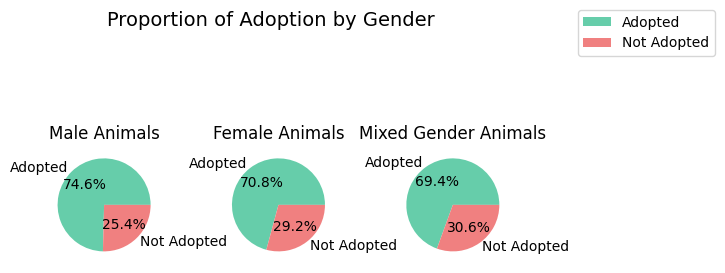

In [177]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))

# Adjust the horizontal spacing between subplots
fig.subplots_adjust(wspace=0.5, hspace=0.1)

labels = ['Adopted', 'Not Adopted']
color = ['mediumaquamarine','lightcoral']
# Plot pie chart for male animals
data_male = df[df['Gender'] == 'Male']
counts_male = data_male['Adopted'].value_counts()
ax1.pie(counts_male, labels=labels, colors=color, autopct='%1.1f%%')
ax1.set_title('Male Animals')

# Plot pie chart for female animals
data_female = df[df['Gender'] == 'Female']
counts_female = data_female['Adopted'].value_counts()
ax2.pie(counts_female, labels=labels, colors=color, autopct='%1.1f%%')
ax2.set_title('Female Animals')

# Plot pie chart for mixed gender animals
data_mixed = df[df['Gender'] == 'Mixed']
counts_mixed = data_mixed['Adopted'].value_counts()
ax3.pie(counts_mixed, labels=labels, colors=color, autopct='%1.1f%%')
ax3.set_title('Mixed Gender Animals')

# Add legend
handles, labels = ax1.get_legend_handles_labels()

# Set the legend outside the plot
fig.legend(handles,labels, bbox_to_anchor=(1, 1), loc='upper left')
plt.suptitle('Proportion of Adoption by Gender', fontsize=14)
# Show the plot
plt.show()

Generally, between adopted and not adopted per gender, for each section, it is hard to see the variance as there is no significant change

## Adoption Rate by Color

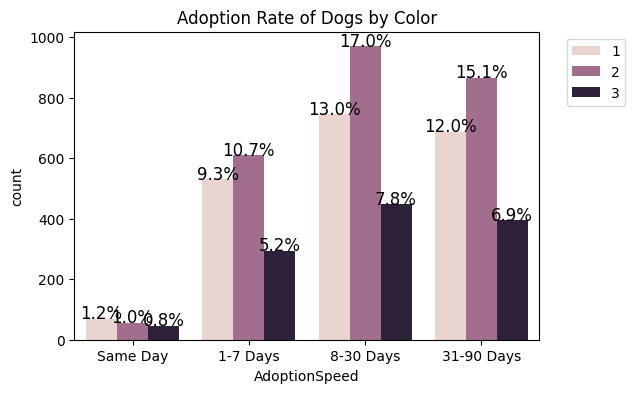

In [180]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='AdoptionSpeed', hue='ColorAmt', order=adoption_speed_list,
                   data=df[(Adopted) & (Dog)])
plt.title('Adoption Rate of Dogs by Color')
percentage_labels(ax, df[(Adopted) & (Dog)])
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

For dogs, among the differences between 3 colors, the highest rate of adoptions are found in 8-30 days

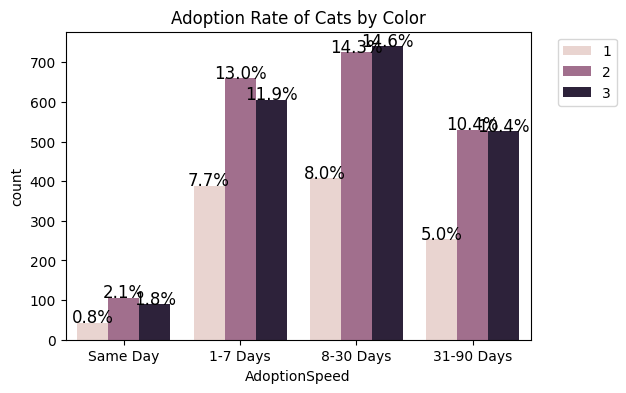

In [181]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='AdoptionSpeed', hue='ColorAmt', 
                   order=adoption_speed_list,
                   data=df[(Adopted) & (Cat)])
plt.title('Adoption Rate of Cats by Color')
percentage_labels(ax, df[(Adopted) & (Cat)])
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

Same like dogs, majority of adoptions are found in 8-30 days

## Adoption rate by Maturity

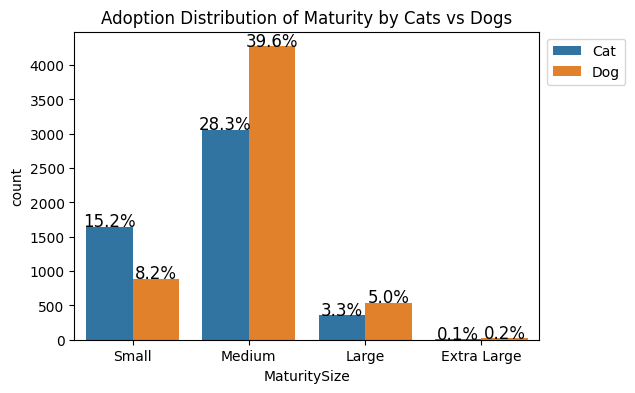

In [182]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='MaturitySize', hue='Type', data=df[Adopted])
plt.title('Adoption Distribution of Maturity by Cats vs Dogs')
percentage_labels(ax, df[Adopted])
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')

For dogs, medium sized dogs are most favourable at 39.6%, same with cats at 28.3%

## Adoption rate by Vaccinated/Dewormed/Sterilized

These should be main important factors when it comes to adopting a put, so it should be expected to see most adopted animals to have all 3 done

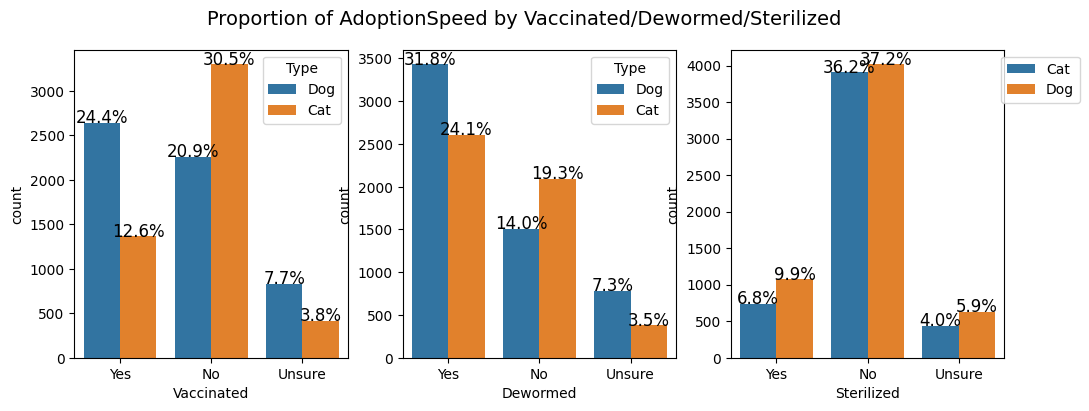

In [184]:
# Create a figure with 1 row and 3 columns
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

custom_ticks = [0, 1, 2]
custom_x_labels = ['Yes', 'No', 'Unsure']

sns.countplot(x='Vaccinated', hue='Type', data=df[Adopted], ax=axs[0])
axs[0].set_xticks(custom_ticks)
axs[0].set_xticklabels(custom_x_labels)
percentage_labels(axs[0], df[Adopted])

ax = sns.countplot(x='Dewormed', hue='Type', data=df[Adopted], ax=axs[1])
axs[1].set_xticks(custom_ticks)
axs[1].set_xticklabels(custom_x_labels)
percentage_labels(axs[1], df[Adopted])

ax = sns.countplot(x='Sterilized', hue='Type', data=df[Adopted], ax=axs[2])
axs[2].set_xticks(custom_ticks)
axs[2].set_xticklabels(custom_x_labels)
percentage_labels(axs[2], df[Adopted])

plt.suptitle('Proportion of AdoptionSpeed by Vaccinated/Dewormed/Sterilized', 
             fontsize=14)

plt.legend(bbox_to_anchor=(1.3, 1), loc='upper right')

Individually, They each have no meaningful representation. This is as considering a safety standpoint, all 3 should be majority yes for those adopted, however the trends for Vaccinated and Sterilized says otherwize, with the highest % of adoption coming from No from these 2 columns. Dewormed fellows the trend of yes being the majority. 

## Adoption Distribution by Quantity

Does number of animal stated affect adoption rate?

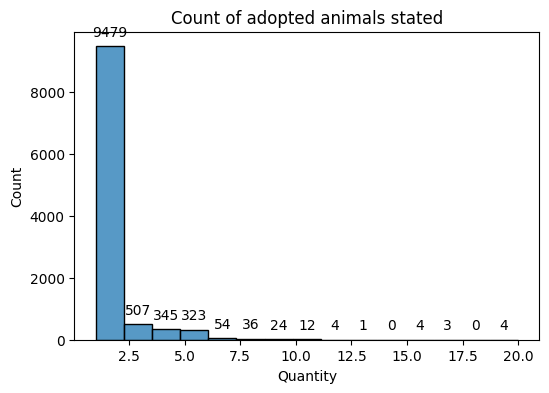

In [186]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=df[Adopted], x="Quantity")
plt.title("Count of adopted animals stated")
count_labels(ax)
plt.show()

As we can see, adopted animals are really only affected by either 1 animal, or >1. Majority would prefer to adopt 1 animal only.

## Distribution of Adoption by Fee

The question is whether cost matters

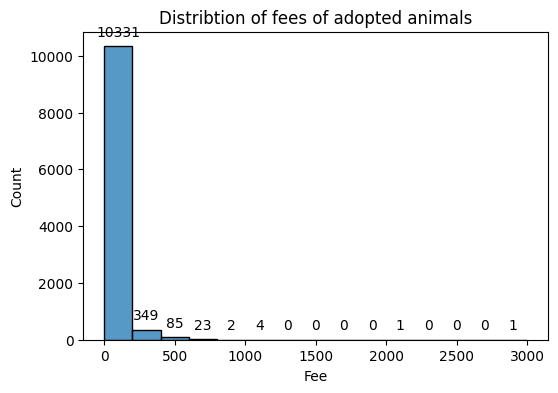

In [187]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(data=df[Adopted], x="Fee")
plt.title("Distribtion of fees of adopted animals")
count_labels(ax)
plt.show()

As we can see, almost all adopted animals are adopted for free, meaning that whether an animal costs money is a big factor

## Adoption Distribution by State

There could be a possibilty that some states prefer certain animals

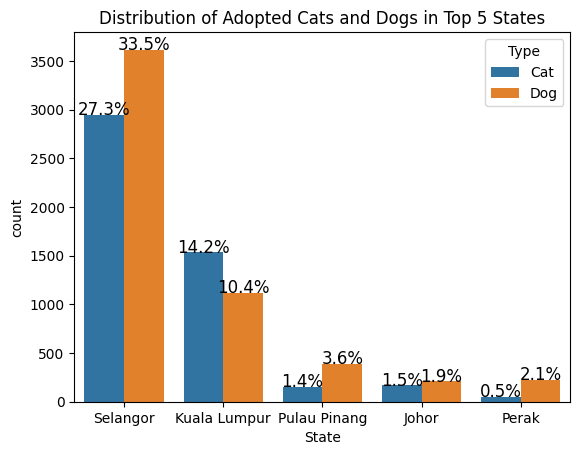

In [188]:
top5 = df['State'].value_counts().head().index.tolist()
filtered_data = df[(Adopted) & (df['State'].isin(top5))]

top5name = []
for i in top5:
    state_name = df_state[df_state["StateID"] == i]['StateName'].values[0]
    top5name.append(state_name)

custom_ticks = [0, 1, 2, 3, 4]
custom_x_labels = top5name
ax = sns.countplot(data=filtered_data, x='State', order=top5, hue='Type')
ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_x_labels)
plt.title("Distribution of Adopted Cats and Dogs in Top 5 States")
percentage_labels(ax, df[Adopted])


As we can see, majority of the animals adopted are from Selangor, followed by KL and Pulau Pinang

## Adoption Distribution by Name

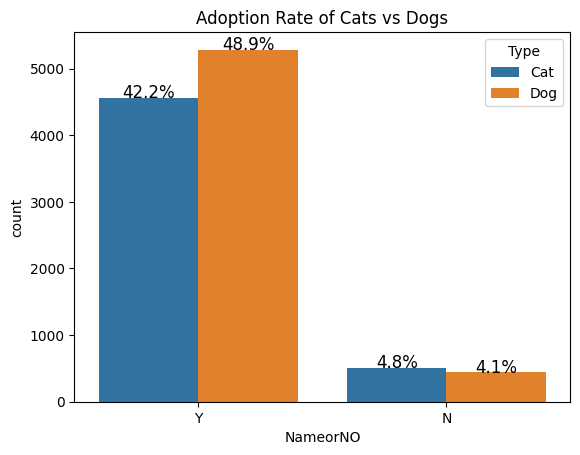

In [189]:
ax = sns.countplot(x='NameorNO', hue='Type', data=df[Adopted])
plt.title('Adoption Rate of Cats vs Dogs')
percentage_labels(ax, df[Adopted])

Evidently, those with names are more likely to be adopted than those with no names

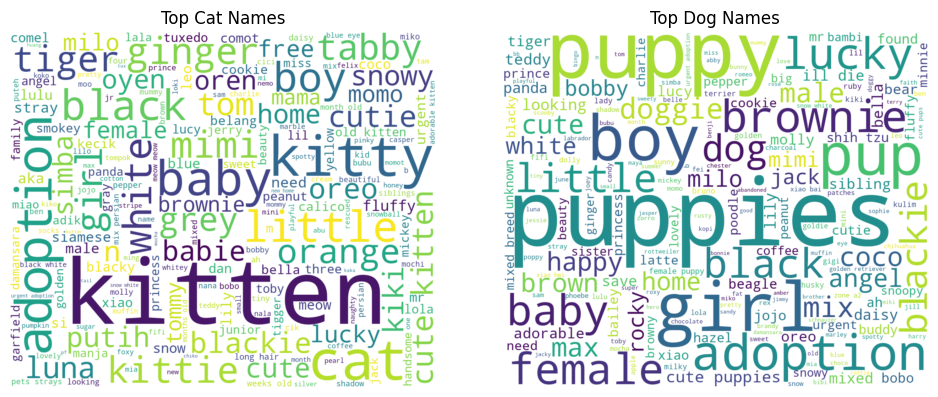

In [190]:
text_cat = ' '.join(df.loc[(Cat) & (df['NameorNO'] == 'Y'), 'NameLower'].values)
text_dog = ' '.join(df.loc[(Dog) & (df['NameorNO'] == 'Y'), 'NameLower'].values)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Generate word cloud for cats
wordcloud_cat = WordCloud(max_font_size=None, background_color='white', 
                          width=1200, height=1000).generate(text_cat)
axs[0].imshow(wordcloud_cat, interpolation='bilinear')
axs[0].set_title('Top Cat Names')
axs[0].axis("off")

# Generate word cloud for dogs
wordcloud_dog = WordCloud(max_font_size=None, background_color='white', 
                          width=1200, height=1000).generate(text_dog)
axs[1].imshow(wordcloud_dog, interpolation='bilinear')
axs[1].set_title('Top Dog Names')
axs[1].axis("off")

plt.tight_layout()
plt.show()

Unfortunately, even after cleaning, it seems that there are many false positives when it comes to whether having a name affects adoption due to generic names being the top of names of adopted animals. Generic names like puppy, puppies populate the dogs and kitten, kitty populate both. Personally, names really shouldnt matter as most likely when you adopt a pet you would give it your own name.

## Adoption Distribution by Video/Photos Amount

With the rise of social media, there is a possiblity that amount of pictures affect it

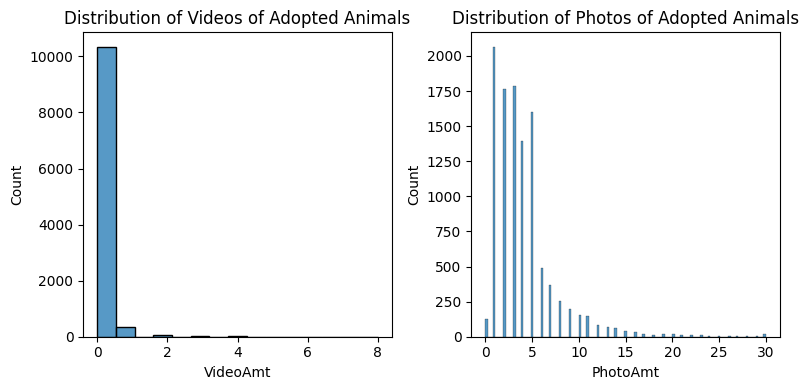

In [191]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(data=df[Adopted], x="VideoAmt", ax=axs[0])
axs[0].set_title("Distribution of Videos of Adopted Animals")

sns.histplot(data=df[Adopted], x="PhotoAmt", ax=axs[1])
axs[1].set_title("Distribution of Photos of Adopted Animals")

plt.tight_layout()
plt.show()

As shown, VideoAmt doesnt affect the likelihood of adoption, as pets with 0 videos are still adopted. However, majority of the pets adopted are found within the 1-5 range

## Summary

After EDA, it seems like more feature engineering is needed, namely for `VideoAmt,PhotoAmt,State,Fee,Color`

Additonally, both types of animals are adopted within 8-30 days across all features in general. These correlate with the amount of animals that are adopted within this time period also.

Features `Fee` seemed to have the highest impact among all as it made sense that people would prefer adopting animals for free rather than paying a price.